# Multigrid Method for solving Laplace's Equation

Physics 3800 Project 2

Author: StudentName - StudentId

Date: February 2020

## 1. Introduction

Solving partial differential equations (PDEs) is a important mathematically problem in many areas of physics.  In the context determine the electric potential we encounter a boundary value problem which involves solving Laplace's equation

$$ \nabla^2 V({\textbf r}) = \frac{\partial ^2 V}{\partial x^2} + \frac{\partial ^2 V}{\partial y^2} = 0.$$

In the course we have considered a few iterative methods for numerically solving this problem including Gauss-Seidel Relaxation and Successive Over Relaxation. The textbook (Gould et al. 2016) introduces the multigrid method as another approach with the following project:

> Project 10.26. Multigrid method
>
> In general, the relaxation method for solving Laplace’s equation is very slow even using overrelaxation. The reason is that the local updates of the relaxation method cannot quickly take into account effects at very large length scales. The *multigrid method* greatly improves performance by using relaxation at many length scales. The important idea is to use a relaxation method tofind the values of the potential on coarser and coarser grids, and then use the coarse grid valuesto determine the fine grid values. The fine grid relaxation updates take into account effects atshort length scales. If we define the initial grid by a lattice spacing $b= 1$, then the coarser gridsare characterized by $b= 2^n$, where $n$ determines the coarseness of the grid and is known as thegrid level. We need to decide how to use the fine grid values of the potential to assign values to a coarser grid, and then how to use a coarse grid to assign values to a finer grid. The first step is called *restriction*  and the second step is called *prolongation*. There is some flexibility on how todo these two operations. We discuss one approach. 
>
>We define the centers of the sites of the coarse grid to be located at the centers of every other site of the fine grid. That is, if the set ${i, j}$ represents the positions of the sites of the fine grid,then ${2i,2j}$ represents the positions of the coarse grid sites. The fine grid sites that are at thesame position as a coarse grid point are assigned the value of the potential of the correspondingcoarse grid point. The fine grid sites that have two coarse grid points as nearest neighbors areassigned the average value of these two coarse grid sites. The other fine grid sites have four coarse grid sites as next nearest neighbors and are assigned the average value of these four coarse grid sites. This prescription specifies how values on the fine grid are computed using the values on the coarse grid.
>
>In the full weighting prolongation method, each coarse grid site receives one fourth of the potential of the fine grid site at the same position, one eighth of the potential for the four nearestneighbor sites of the fine grid, and one sixteenth of the potential for the four next nearest neighborpoints of the fine grid. The sum of these fractions, $1/4 + 4(1/8) + 4(1/16)$, adds up to unity. An alternative procedure, known as half weighting, ignores the next nearest neighbors and uses one half of the potential of the fine grid site at the same position as the coarse grid site.
>
> a. Write a program that implements the multigrid method using Gauss-Seidel relaxation on a checkerboard lattice (see Problem 10.11b). In its simplest form the program should allow the user to intervene and decide whether to go to a finer or coarser grid, or to remain at the same level for the next relaxation step.  Have the program print the potential at each site of the current level after each relaxation step. Test your program on a 4×4 grid whose boundary sites are all equal to unity, and whose initial internal sites are set to zero. Make sure that the boundary sites of the coarser grids also are set to unity.
>
> b.The exact solution for part (a) gives a potential of unity at each point. How many relaxation steps does it take to reach unity within 0.1% at every site by simply using the 4×4 grid? How many steps does it take if you use one coarse grid and continue until the coarse grid values are within 0.1% of unity? Is it necessary to carry out any fine grid relaxation steps to reach the desired accuracy on the fine grid? Next start with the coarsest scale, which is just one site. How many relaxation steps does it take now?
> 
> c. Repeat part (b), but change the boundary so that one side of the boundary is held at a potential of 0.5. Experiment with different sequences of prolongation, restriction, and relaxation.
> 
> d. Assume that the boundary points alternate between zero and unity, and repeat part (b). Does the multigrid method work? Should one go up and down in levels many times instead of staying at the coarsest level and then going down to the finest level?

According to the errata "Updates and Corrections to the Third Edition" for (Gould et. al, 2016) it notes that that *the word "prolongation" should be replaced by "restriction" and the word "restriction" should be replaced by "prolongation".* We will use those corrected terms for the rest of this project report.

## 2. Method

## 3. Verification of Program

## 4. Data

## 5. Analysis



## 6. Interpretation


## 7. Critique


## 8. References


Gould H., Tobochnik J., Christian W. An Introduction to Computer Simulation Methods Third Edition (revised), 2016.

## Appendix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

As motivating problem, solve Laplace's equation on a $N \times N$ square grid with boundary values of unity. Use an initial value for $V=0$ for the interior sites. We know that the exact solution to this problem is $V = 1$ everywhere so the error at any step in an iterative method is

$$ error = 1 - V$$

For visualization we will need a grid. Here we use `Xc, Yc` to represent the grid centres and `Xe, Ye` to represent the grid edges. Note that the size of the edge grid is one larger than the size of the centre grid.

In [61]:
N = 8
Xc, Yc = np.mgrid[0:N, 0:N]
Xe, Ye = np.mgrid[-0.5:N+0.5, -0.5:N+0.5]

We initialize the problem by creating an array `V` to store the values of the potential.  The boundary values are set to be unity ($V=1$) and the interior points are initialized to be zero.  

In [71]:
isConductor = np.zeros((N, N), dtype=bool)
V = np.zeros((N, N), dtype=float)

isConductor[0, :] = True
V[0, :] = 1
isConductor[-1, :] = True
V[-1, :] = 1
isConductor[:, 0] = True
V[:, 0] = 1
isConductor[:, -1] = True
V[:, -1] = 1

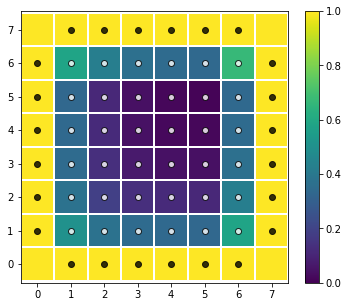

In [76]:
def plotV(V):
    plt.figure(figsize=(6, 5))
    
    plt.pcolormesh(Xe, Ye, V, 
                   edgecolor='w', vmin=0, vmax=1)
    plt.colorbar(orientation='vertical')

    plt.scatter(Xc[1:-1, 1:-1], Yc[1:-1, 1:-1], 
                edgecolor='k', color='w', alpha=0.8)

    for i in [ (0, slice(1, -1)),
               (-1, slice(1, -1)),
               (slice(1, -1), 0),
               (slice(1, -1), -1)]:
        plt.scatter(Xc[i], Yc[i],  color='k', alpha=0.8)

    plt.axis('equal')

plotV(V)

In [65]:
def GaussSeidelStep(V):
    N, _ = V.shape
    
    for i in range(1, N-1):
        for j in range(1, N-1):
            if not isConductor[i, j]:
                v = (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1])/4
                dv = V[i, j] - v
                V[i, j] = v
    return V

In [73]:
V = GaussSeidelStep(V)

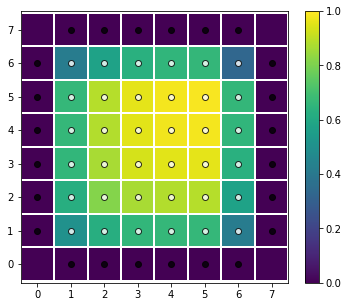

In [75]:
plotV(1-V)